# Проект E-commerce 

## Задание 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.


## Файлы:

**olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей:
- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

**olist_orders_dataset.csv** —  таблица заказов:
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

Уникальные статусы заказов в таблице **olist_orders_dataset**:
- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [1]:
#загружаем бибилиотеки
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Загружаем исходные данные 
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pershanova-17/datasets/olist_customers_dataset.csv')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pershanova-17/datasets/olist_order_items_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pershanova-17/datasets/olist_orders_dataset.csv')

In [3]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [5]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [6]:
# 1.1 Объединяем датасеты customers и orders для сопоставления 'customer_unique_id', 'customer_id' и 'order_id'
orders_with_unique_id = orders.merge(customers[['customer_unique_id','customer_id']], on='customer_id')

In [7]:
orders_with_unique_id.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8


In [8]:
# 1.2 Совершившими покупку считаем тех пользователей, которые совершили оплату созданного заказа
# 1.3 Фильтруем строки таблицы, исключая заказы со статусом 'canceled','unavailable' и неоплаченные заказы
# 1.4 Группируем по уникальному номеру пользователя и считаем количество заказов на пользователя
# 1.5 Отбираем пользователей с количеством заказов = 1 и считаем количество таких пользователей
orders_with_unique_id['order_approved_at'] = orders_with_unique_id.order_approved_at.fillna(0)
orders_with_unique_id.query('order_status != "canceled" & order_status != "unavailable" & order_approved_at != 0')\
              .groupby('customer_unique_id', as_index=False)\
              .agg({'order_id':'count'})\
              .query('order_id == 1')\
              .count()

customer_unique_id    92087
order_id              92087
dtype: int64

Посмотрим, сколько у нас всего уникальных id пользователей и сравним с полученным числом пользователей с одним заказом.
По полученным результатам видно, что большинство из всех покупателей совершило всего одну покупку, это 96096 пользователей.

In [9]:
customers.customer_unique_id.nunique()

96096

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [10]:
# 2.1 Для расчета возьмем все заказы, по которым была назначена дата доставки.
# Приводим столбец с обещанной датой доставки заказа к формату даты и создаем дополнительный столбец, куда выводим значение месяц-год
orders['order_estimated_delivery_date_month'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.to_period('M')
# 2.2 Отбираем заказы, которые были отменены или стали недоступны
# 2.3 Группируем по статусу и месяцу назначенной доставки
# 2.4 Считаем количество заказов помесячно по каждой причине 
orders.query('order_status == "canceled" or order_status == "unavailable"')\
.groupby(['order_status','order_estimated_delivery_date_month'],as_index=False)\
.agg({'order_id':'count'})\
.pivot(index='order_status', columns='order_estimated_delivery_date_month', values='order_id')

order_estimated_delivery_date_month,2016-09,2016-10,2016-11,2016-12,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11
order_status,,,,,,,,,,,,,,,,,,,,,
canceled,1.0,3.0,14.0,8.0,2.0,26.0,22.0,23.0,29.0,21.0,...,32.0,88.0,17.0,26.0,11.0,26.0,72.0,49.0,12.0,1.0
unavailable,NaN,NaN,5.0,2.0,2.0,66.0,19.0,16.0,29.0,34.0,...,40.0,34.0,11.0,12.0,7.0,7.0,22.0,NaN,NaN,NaN


In [11]:
# 2.5 Находим среднее в месяц по каждой причине
orders.query('order_status == "canceled" or order_status == "unavailable"')\
.groupby(['order_status','order_estimated_delivery_date_month'],as_index=False)\
.agg({'order_id':'count'})\
.pivot(index='order_status', columns='order_estimated_delivery_date_month', values='order_id')\
.mean(axis=1)

order_status
canceled       24.038462
unavailable    29.000000
dtype: float64

В итоге видим, что в среднем в месяц отменяется 24 заказа, стали недоступными 29 заказов.
Проверим, сколько заказов в среднем делается в месяц и сравним данные.

In [12]:
orders.query('order_status != "canceled" or order_status != "unavailable"')\
.groupby(['order_estimated_delivery_date_month'],as_index=False)\
.agg({'order_id':'count'})

,order_estimated_delivery_date_month,order_id
0,2016-09,1
1,2016-10,6
2,2016-11,171
3,2016-12,148
4,2017-01,3
5,2017-02,316
6,2017-03,2801
7,2017-04,2235
8,2017-05,3037
9,2017-06,3639


Среднее число отмененных заказов составляет около одного процента от среднего числа заказов в месяц.
Возможно оценка по среднему не совсем корректна в данной ситуации, так как количество заказов достаточно сильно варьируется от месяца к месяцу, в последние месяцы наблюдается снижение числа заказов, хотя резкого роста отмен нет

In [13]:
orders.query('order_status != "canceled" or order_status != "unavailable"')\
.groupby(['order_estimated_delivery_date_month'],as_index=False)\
.agg({'order_id':'count'}).mean()

order_id    3683.0
dtype: float64

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [14]:
# 3.1 Добавляем к таблице товаров дату создания заказа, приводим дату к названию дня недели
items_with_date = items.merge(orders[['order_id','order_purchase_timestamp']], on='order_id')
items_with_date['order_purchase_timestamp'] = pd.to_datetime(items_with_date.order_purchase_timestamp).dt.day_name()

In [15]:
# 3.2 Группируем по id товара и дню недели, подсчитываем количество покупок по дням
items_by_day = items_with_date.groupby(['product_id', 'order_purchase_timestamp'], as_index=False).agg({'order_id':'count'})\
.sort_values('order_purchase_timestamp')\
.pivot(index='product_id', columns='order_purchase_timestamp', values='order_id').fillna(0)

In [16]:
# 3.3 Выводим в последнем столбце день недели, когда товар заказывается чаще всего
items_by_day['max_day'] = items_by_day.idxmax(axis=1)
items_by_day.head()

order_purchase_timestamp,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,max_day
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sunday
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tuesday
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Thursday
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Friday
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tuesday


In [17]:
items_by_day.max()

order_purchase_timestamp
Friday              87
Monday              92
Saturday            61
Sunday              62
Thursday            89
Tuesday             85
Wednesday           93
max_day      Wednesday
dtype: object

In [18]:
# Больше всего товаров, у которых самый частый день заказа - понедельник
items_by_day.max_day.value_counts()

Monday       6295
Friday       6058
Tuesday      4495
Thursday     4453
Wednesday    4128
Sunday       3806
Saturday     3716
Name: max_day, dtype: int64

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [19]:
# 4.1 Приведем дату к месяцу и подсчитаем количество покупок в месяц для каждого пользователя
orders_with_unique_id['order_purchase_timestamp_month'] = pd.to_datetime(orders.order_purchase_timestamp).dt.to_period('M')
orders_by_month = orders_with_unique_id.groupby(['customer_unique_id','order_purchase_timestamp_month'], as_index=False)\
                                       .agg({'order_id':'count'}).sort_values('customer_unique_id')

In [20]:
# 4.2 Добавим столбец с количеством недель в месяце 'weeks' и столбец искомой метрики 'orders_per_week'
orders_by_month['weeks'] = orders_by_month['order_purchase_timestamp_month'].dt.daysinmonth/7
orders_by_month['orders_per_week'] = orders_by_month['order_id']/orders_by_month['weeks']
orders_by_month = orders_by_month.rename({'order_id':'orders_in_month'}, axis=1)
orders_by_month.head(10)

,customer_unique_id,order_purchase_timestamp_month,orders_in_month,weeks,orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04,1,4.285714,0.233333
6,00050ab1314c0e55a6ca13cf7181fecf,2018-04,1,4.285714,0.233333
7,00053a61a98854899e70ed204dd4bafe,2018-02,1,4.000000,0.250000
8,0005e1862207bf6ccc02e4228effd9a0,2017-03,1,4.428571,0.225806
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2018-03,1,4.428571,0.225806


Согласно полученным данным пользователи делают не больше одной покупки в неделю в месяц. В целом, число покупок в неделю по месяцам достаточно низкое, это также связано с тем, что большинство пользователей в приницпе сделало всего один заказ в магазине

In [21]:
orders_by_month.sort_values('orders_per_week')

,customer_unique_id,order_purchase_timestamp_month,orders_in_month,weeks,orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
57225,95828271d6bee6d5eedcd00e639d67a6,2018-08,1,4.428571,0.225806
57226,95834cf255d8c39ea415b7e35272ca13,2017-12,1,4.428571,0.225806
57228,9585898e80f9de26178eb04cd600b6f5,2017-08,1,4.428571,0.225806
57229,958843e128a10a8ae35155b6fc57fec3,2018-03,1,4.428571,0.225806
...,...,...,...,...,...
14489,25a560b9a6006157838aab1bdbd68624,2017-04,4,4.285714,0.933333
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.000000,1.000000
69396,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,4.000000,1.000000
23943,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.000000,1.000000


### 5. Напиши функцию на python, позволяющую строить когортный анализ. 
В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

In [22]:
# 5.1 Подготовим данные: выберем из таблицы заказов, включающей уникальные id пользователей, 
# нужные столбцы - id пользователя и заказа, дату создания заказа, исключив отмненнные и недоступные заказы.
customer_and_orders = orders_with_unique_id.query('order_status !="unavailable"' or 'order_status !="canceled"')[['customer_unique_id','order_id','order_purchase_timestamp']]
customer_and_orders.order_purchase_timestamp = pd.to_datetime(customer_and_orders.order_purchase_timestamp)
customer_and_orders.head()

,customer_unique_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [23]:
# 5.2 Объявим функции для расчета retention
# Функция cohorts (позволяет разделить пользователей на когорты по году и месяцу первого заказа и рассчитать размеры когорт)

def cohorts(data_customer):
    cohorts = data_customer.groupby('customer_unique_id', as_index=False)\
                     .agg({'order_purchase_timestamp':'min'})\
                     .sort_values('order_purchase_timestamp') 
    cohorts['cohort'] = pd.to_datetime(cohorts.order_purchase_timestamp).dt.to_period('M') #Определяем когорты
    
    cohorts_size = cohorts.groupby('cohort',as_index=False).agg({'customer_unique_id':'count'}) #Определяем размер когорт
    cohorts_size = cohorts_size.rename(columns={'customer_unique_id':'cohorts_size'})
    
    return cohorts_size

# Функция retention принимает таблицу с данными, возвращает коэффициент удержания в процентах

def retention(data_customer):
    # Блок из функции для расчета когорт
    cohorts = data_customer.groupby('customer_unique_id', as_index=False)\
                               .agg({'order_purchase_timestamp':'min'})\
                               .sort_values('order_purchase_timestamp')
    cohorts['cohort'] = pd.to_datetime(cohorts.order_purchase_timestamp).dt.to_period('M') 

    cohorts_size = cohorts.groupby('cohort',as_index=False).agg({'customer_unique_id':'count'})
    cohorts_size = cohorts_size.rename(columns={'customer_unique_id':'cohorts_size'})

    #Присваиваем когорту пользователю, определяем месяц-год каждого заказа
    customer_orders_cohorts = data_customer.merge(cohorts[['customer_unique_id','cohort']], on='customer_unique_id') 
    customer_orders_cohorts['order_month'] = pd.to_datetime(customer_orders_cohorts.order_purchase_timestamp).dt.to_period('M')
    
    #Создаем промежуточную таблицу, где показано количество пользователей по когортам, делающих заказ в месяц
    retention_customer = customer_orders_cohorts.groupby(['cohort','order_month'],as_index=False )\
    .agg({'customer_unique_id':'nunique'}).sort_values('cohort')\
    .pivot(index = 'cohort', columns ='order_month', values='customer_unique_id').fillna(0)
    
    #Считаем retention
    retention = ((retention_customer/cohorts_size.cohorts_size.values)*100).round(2)
 
    return retention

def retention_period(data_retention, start = '2016-12', end = '2017-02'):
    retention_period = data_retention.loc[:, start:end][start:end]
    return retention_period

In [24]:
# Объявленные когорты и их размер
cohorts(customer_and_orders)

,cohort,cohorts_size
0,2016-09,4
1,2016-10,314
2,2016-12,1
3,2017-01,754
4,2017-02,1707
5,2017-03,2604
6,2017-04,2343
7,2017-05,3566
8,2017-06,3115
9,2017-07,3848


In [25]:
# Данные по retention
retention(customer_and_orders)

order_month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2016-10,0.0,100.0,0.0,0.00,0.00,0.00,0.04,0.00,0.00,0.03,...,0.01,0.00,0.01,0.00,0.03,0.03,0.00,0.00,0.0,0.0
2016-12,0.0,0.0,100.0,0.13,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
2017-01,0.0,0.0,0.0,100.00,0.18,0.08,0.04,0.08,0.03,0.08,...,0.07,0.05,0.01,0.01,0.03,0.05,0.00,0.02,0.0,0.0
2017-02,0.0,0.0,0.0,0.00,100.00,0.15,0.21,0.06,0.22,0.05,...,0.07,0.03,0.04,0.03,0.02,0.02,0.07,0.00,0.0,0.0
2017-03,0.0,0.0,0.0,0.00,0.00,100.00,0.55,0.28,0.32,0.23,...,0.14,0.05,0.09,0.04,0.06,0.10,0.03,0.06,0.0,0.0
2017-04,0.0,0.0,0.0,0.00,0.00,0.00,100.00,0.39,0.16,0.10,...,0.06,0.09,0.03,0.03,0.02,0.03,0.03,0.06,0.0,0.0
2017-05,0.0,0.0,0.0,0.00,0.00,0.00,0.00,100.00,0.58,0.44,...,0.13,0.16,0.13,0.18,0.14,0.02,0.12,0.14,0.0,0.0
2017-06,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.39,...,0.10,0.06,0.10,0.15,0.17,0.08,0.07,0.10,0.0,0.0


In [26]:
# Данные по retention для когорт 2017 года + 3 месяца для анализа по заданию
result = retention(customer_and_orders)
retention_period(result, start = '2017-01', end = '2018-03')
# Самый высокий retention для майской когорты 05-2017, составил 0.34%

order_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
cohort,,,,,,,,,,,,,,,
2017-01,100.0,0.18,0.08,0.04,0.08,0.03,0.08,0.02,0.02,0.00,0.04,0.02,0.07,0.05,0.01
2017-02,0.0,100.00,0.15,0.21,0.06,0.22,0.05,0.10,0.07,0.05,0.04,0.04,0.07,0.03,0.04
2017-03,0.0,0.00,100.00,0.55,0.28,0.32,0.23,0.10,0.10,0.18,0.12,0.04,0.14,0.05,0.09
2017-04,0.0,0.00,0.00,100.00,0.39,0.16,0.10,0.19,0.15,0.18,0.10,0.13,0.06,0.09,0.03
2017-05,0.0,0.00,0.00,0.00,100.00,0.58,0.44,0.34,0.27,0.27,0.21,0.09,0.13,0.16,0.13
2017-06,0.0,0.00,0.00,0.00,0.00,100.00,0.39,0.26,0.29,0.18,0.17,0.22,0.10,0.06,0.10
2017-07,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.48,0.34,0.20,0.15,0.15,0.17,0.06,0.10
2017-08,0.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.71,0.32,0.15,0.28,0.32,0.19,0.16
2017-09,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.63,0.30,0.22,0.26,0.14,0.13


### 6. Построй RFM-кластеры для пользователей. 
Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).

In [27]:
# 6.1 Подготовим данные:
# создадим таблицу, куда войдут уникальные id покупателей, id заказов, дата заказа и общая стоимость заказа 
order_revenue = items.groupby('order_id',as_index=False).agg({'price':'sum'})
customer_order_revenue = customer_and_orders.merge(order_revenue, on='order_id')
customer_order_revenue.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90


**Подготовим данные по метрикам**

*Monetary* — общая сумма покупок клиента: используем исходную таблицу и суммируем все траты каждого пользователя

In [28]:
monetary = customer_order_revenue.groupby('customer_unique_id', as_index=False).agg({'price':'sum'}).rename(columns = {'price':'monetary'})

In [29]:
monetary.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


*Recency* — давность, показывает количество дней с даты последней покупки: нахожу последнюю дату покупки по каждому пользователю, а для расчета метрики считаю разницу с датой 2018-11-01 00:00:00 (для удобства, так как данные от 2018 года, чтобы искусственно не увеличивать значения)

In [30]:
recency = customer_order_revenue.groupby('customer_unique_id', as_index=False).agg({'order_purchase_timestamp':'max'})
recency['recency'] = (datetime.strptime("2018-11-01 00:00:00", "%Y-%m-%d %H:%M:%S")-recency['order_purchase_timestamp']).dt.days

In [31]:
recency = recency.drop(columns={'order_purchase_timestamp'})
recency.head()

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,174
1,0000b849f77a49e4a4ce2b2a4ca5be3f,177
2,0000f46a3911fa3c0805444483337064,600
3,0000f6ccb0745a6a4b88665a16c9f078,384
4,0004aac84e0df4da2b147fca70cf8255,351


*Frequency* - число покупок, суммируем количество заказов пользователя

In [32]:
frequency = customer_order_revenue.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'}).rename(columns = {'order_id':'frequency'})

In [33]:
frequency.head()

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [34]:
# Формируем сводную таблицу
RFM = pd.merge(monetary, recency, on='customer_unique_id')
RFM = pd.merge(RFM,frequency, on='customer_unique_id')
RFM

,customer_unique_id,monetary,recency,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,174,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,177,1
2,0000f46a3911fa3c0805444483337064,69.00,600,1
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,384,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,351,1
...,...,...,...,...
95409,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,510,1
95410,fffea47cd6d3cc0a88bd621562a9d061,64.89,325,1
95411,ffff371b4d645b6ecea244b27531430a,89.90,631,1
95412,ffff5962728ec6157033ef9805bacc48,115.00,182,1


**Разделяем всех клиентов на кластеры:**

*По давности заказа:*
- 1 — давние клиенты;
- 2 — относительно недавние клиенты;
- 3 — недавние клиенты.
    
*По частоте покупок:*
- 1 — покупает очень редко (единичные заказы);
- 2 — покупает нечасто;
- 3 — покупает часто.
    
*По сумме покупок:*
- 1 — маленькая сумма покупок;
- 2 — средняя сумма покупок;
- 3 — большая сумма покупок.

In [35]:
# Для разделения используем квантили (0.33, 0.66), которые поделят выборки значений по каждой отдельной метрике на три части.
quantiles = RFM.quantile(q=[0.33, 0.66])
quantiles = quantiles.to_dict()

# Объявим функцию для присвоения оценки
def RScore(x,p,d):
     if x <= d[p][0.33]:
         return 1
     elif x <= d[p][0.66]:
         return 2
     else:
         return 3

# Создаем в таблице столбы с оценкой по метрикам
RFM['r_score'] = RFM['recency'].apply(RScore, args=('recency',quantiles,))
RFM['f_score'] = RFM['frequency'].apply(RScore, args=('frequency',quantiles,))
RFM['m_score'] = RFM['monetary'].apply(RScore, args=('monetary',quantiles,))

# Формируем столбец с общей оценкой
RFM['RFMScore'] = RFM.r_score.map(str) + RFM.f_score.map(str) + RFM.m_score.map(str)

In [36]:
RFM.head()

,customer_unique_id,monetary,recency,frequency,r_score,f_score,m_score,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,174,1,1,1,3,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,177,1,1,1,1,111
2,0000f46a3911fa3c0805444483337064,69.00,600,1,3,1,2,312
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,384,1,3,1,1,311
4,0004aac84e0df4da2b147fca70cf8255,180.00,351,1,3,1,3,313


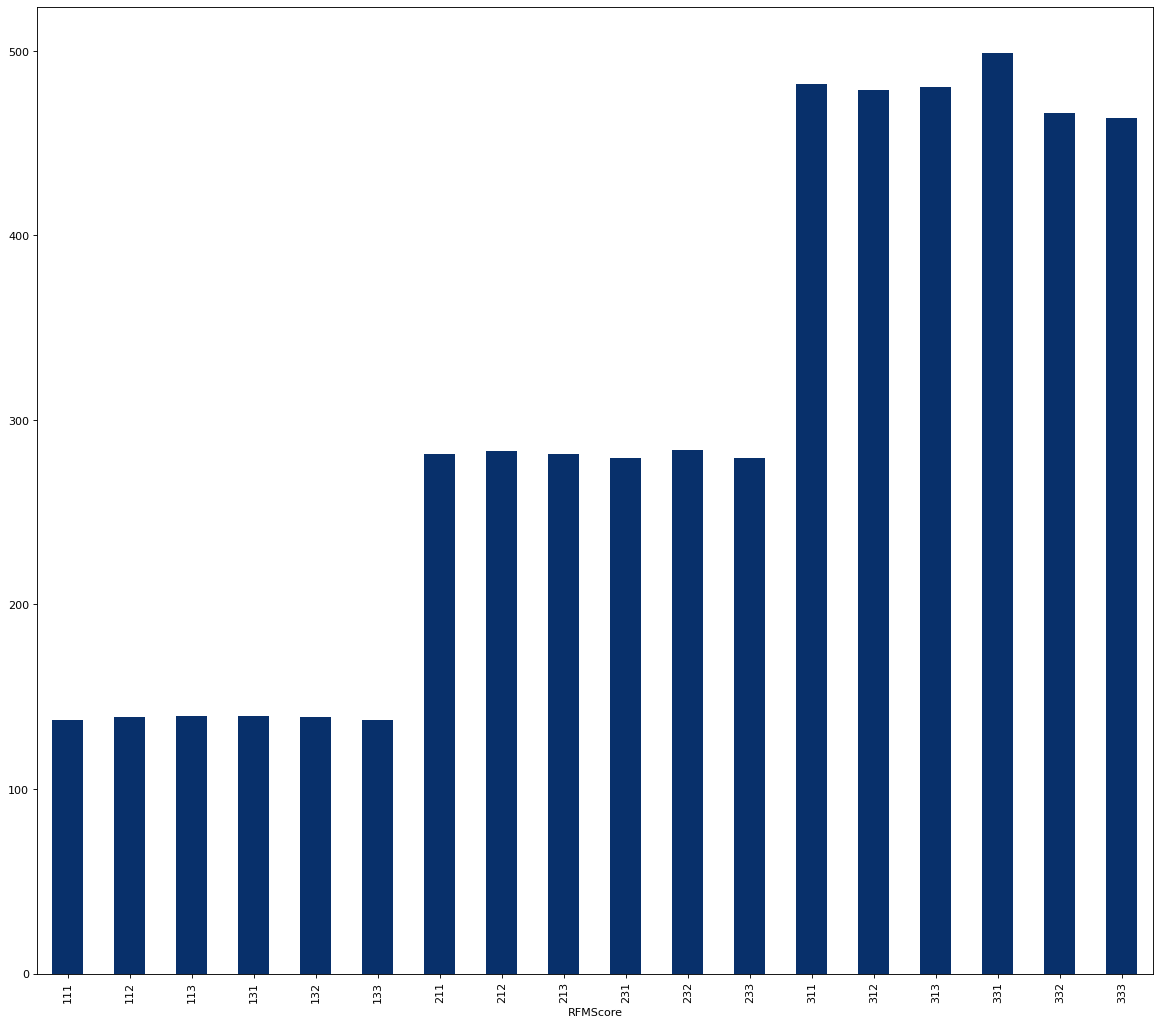

In [37]:
# Распределение пользователей по оценкам
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
RFM.groupby('RFMScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

In [38]:
RFM.groupby('RFMScore', as_index=False).agg({'customer_unique_id':'count'})

,RFMScore,customer_unique_id
0,111,10228
1,112,10298
2,113,10101
3,131,64
4,132,250
5,133,744
6,211,10514
7,212,9896
8,213,9992
9,231,57


Мы получили не совсем корректное разделение, потеряв часть кластеров из-за явной диспропорции в распределении пользователей по количеству заказов: большинство сделало только один заказ.
Посмотрим ниже распределение пользователей по количеству заказов, чтобы определить интервалы для frequency.

In [39]:
frequency.groupby('frequency',as_index=False).agg({'customer_unique_id':'count'})

,frequency,customer_unique_id
0,1,92501
1,2,2673
2,3,192
3,4,29
4,5,9
5,6,5
6,7,3
7,9,1
8,16,1


In [40]:
# Зададим вручную интервалы для frequency

def RScore_f(x):
     if x <= 1:
         return 1
     elif x > 1 and x <= 4:
         return 2
     else:
         return 3

RFM['f_score'] = RFM['frequency'].apply(RScore_f, args=())
RFM['RFMScore'] = RFM.r_score.map(str) + RFM.f_score.map(str) + RFM.m_score.map(str)
RFM.groupby('RFMScore', as_index=False).agg({'customer_unique_id':'count'})

,RFMScore,customer_unique_id
0,111,10228
1,112,10298
2,113,10101
3,121,64
4,122,250
5,123,733
6,133,11
7,211,10514
8,212,9896
9,213,9992


Часть кластеров осталась не заполненной, но полученный результат гораздо лучше отражает ситуацию.

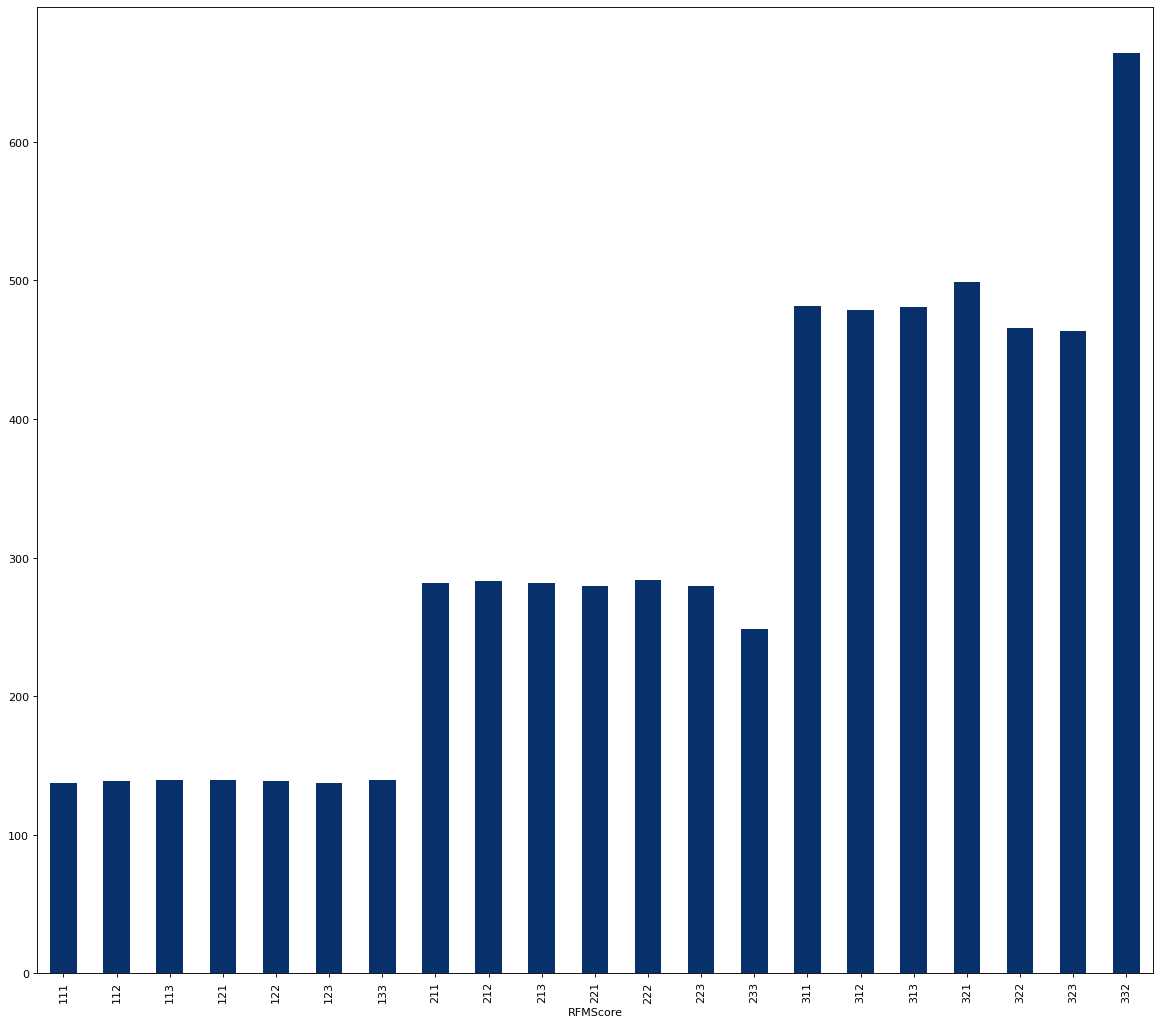

In [41]:
# Распределение пользователей по оценкам
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
RFM.groupby('RFMScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

Определим средние значения метрик R, F, M для каждого кластера

In [42]:
RFM.groupby('RFMScore', as_index=False)['monetary','recency', 'frequency'].mean()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,RFMScore,monetary,recency,frequency
0,111,34.715352,137.321862,1.000000
1,112,89.517374,138.730627,1.000000
2,113,302.618602,139.685873,1.000000
3,121,43.012188,139.625000,2.000000
4,122,94.303480,139.028000,2.044000
5,123,350.104775,137.592087,2.144611
6,133,677.062727,139.727273,6.636364
7,211,34.792976,281.415351,1.000000
8,212,88.954782,283.133286,1.000000
9,213,279.985097,281.744496,1.000000
